In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import ncxt_sxtcnn 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loaders
The loader acts as the link between the annotated SXT data and the task in hand. The loader transforms both the LAC (e.g., normalization) of the image and the annotated mask (material values) to a common format and wraps everything into an iterable class.

Loaders can be extended to include more that one channel fo input data.

In [23]:
from ncxt_sxtcnn.sxtcnn.dataloaders import NCXTMockLoader
loader = NCXTMockLoader(shape=(32, 32, 32), labels=3, length=3)

print("Loader is an iterable class of samples.\nEach sample contains:\n")
item = loader[0]
for k,v in item.items():
    if isinstance(item[k], np.ndarray):
        print(k, v.shape)
    else:
        print(k,v)

Loader is an iterable class of samples.
Each sample contains:

input (1, 32, 32, 32)
target (32, 32, 32)
key {'material_0': 0, 'material_1': 1, 'material_2': 2}


NCXTDBLoader feeds of an argument database, so that thte __getitem__ loads the actual data
``` python
def __getitem__(self, index):
        record = self.db[index]
        lac = read_mrc(record["data"])
        label = read_mrc(record["annotation"])
```

For use on new data, it's convenient to define e.g.
``` python
def __call__(self, data):
        retval = self.required_pre_processing_of_the_data(data)    
        return retval.reshape(1, *retval.shape)
```
The CNN eats 4d arrays, where the first dimension is the number of channels.
For pure LAC, we reshape it onto (1,*shape)

## Processor
Processors act as the intermediate dataflow from the whole samples into processable blocks.

to conform to a common standard, derive class from the ABC
DataProcessor, which contains three abstarc methods:
 - forward(self,data) -- from data to network intput 
 - backward(self, data) -- from network output to processed volume
 - init_data(*args)  -- Because of memory limitations, we initialize the train and test data to a temporary working directory. Init_data handles the serialization of this data.


In [11]:
processor = ncxt_sxtcnn.datainitializers.RandomBlockProcessor(
    block_shape=(8,8,8), 
    binning=2,  
    sampling=1.0)

## Model
The models are derived from torch.nn.Module

In [17]:
model = ncxt_sxtcnn.sxtcnn.models.UNet3D(3)
model.summary((1,8,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1          [-1, 32, 8, 8, 8]             896
            Conv3d-2          [-1, 32, 8, 8, 8]          27,680
         MaxPool3d-3          [-1, 32, 4, 4, 4]               0
          DownConv-4  [[-1, 32, 4, 4, 4], [-1, 32, 8, 8, 8]]               0
            Conv3d-5          [-1, 64, 4, 4, 4]          55,360
            Conv3d-6          [-1, 64, 4, 4, 4]         110,656
         MaxPool3d-7          [-1, 64, 2, 2, 2]               0
          DownConv-8  [[-1, 64, 2, 2, 2], [-1, 64, 4, 4, 4]]               0
            Conv3d-9         [-1, 128, 2, 2, 2]         221,312
           Conv3d-10         [-1, 128, 2, 2, 2]         442,496
         DownConv-11  [[-1, 128, 2, 2, 2], [-1, 128, 2, 2, 2]]               0
  ConvTranspose3d-12          [-1, 64, 4, 4, 4]          65,600
           Conv3d-13          [-1, 64, 4, 4, 4]         221,24

## Wrap it up!

In [18]:
params = {
    "name": f"example",
    "device": "cpu",
    "working_directory": '__tempwd__/',
}
seg = ncxt_sxtcnn.sxtcnn.sxt_cnn_wrapper.SXT_CNN_WRAPPER(
    loader, model, processor, params=params)

seg.init_data(train_idx=[0,1], test_idx=[2,])
# calls the assigned processors init_data() method
# and stores the test and training data in the working directory

Data folder __tempwd__\train already exists


Training for 10 epochs


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

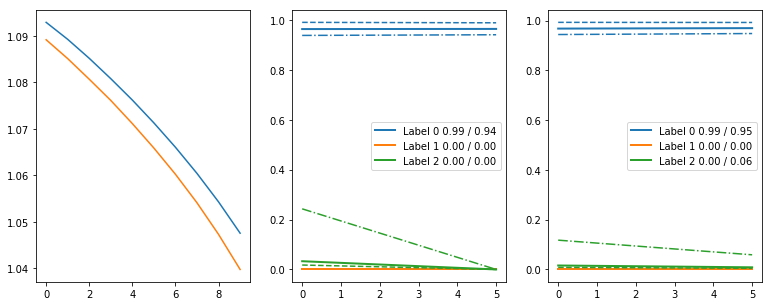

In [19]:
seg.run()
seg.plot_train()

## Input of raw (unseen) images
Default forward and backward method for Processors (as for RandomBlockProcessor)

As the data is done via extracted and fused blocks of data, 
the input does not have to be of any specific size.

In [30]:
test_data = np.random.random((31,32,21))
input_data  = loader(test_data)
output_data = seg.apply(input_data)